In [1]:
# import logging
# logging.captureWarnings(True)
# logging.getLogger('py.warnings').setLevel(logging.ERROR)

import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
from scipy import stats
import scipy
from scipy.interpolate import make_interp_spline, BSpline
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
# from dask.distributed import Client, progress
# from datetime import datetime, timedelta

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

%matplotlib inline
from IPython.display import Image, display

In [2]:
## timestep for plots 
m = 6

## Latitude and longitude of Santa Barbara
SB_lat = 34.5
SB_lon = -119.5+360

# ## location of maxiumum lightning strikes between 4 and 5 UTC 6 March 2019
# SB_lat = 34.0
# SB_lon = -120.0+360.0

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=SB_lat, longitude=SB_lon)

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2/2019*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 0.00

xarray.Dataset {
dimensions:
	time = 9 ;

variables:
	float64 latitude() ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	float64 longitude() ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	datetime64[ns] time(time) ;
		time:long_name = verification time generated by wgrib2 function verftime() ;
		time:reference_time_type = 1 ;
		time:reference_time_description = analyses, reference date is fixed ;
		time:time_step_setting = auto ;
		time:time_step = 0.0 ;
	float32 PRES_meansealevel(time) ;
		PRES_meansealevel:short_name = PRES_meansealevel ;
		PRES_meansealevel:long_name = Pressure ;
		PRES_meansealevel:level = mean sea level ;
		PRES_meansealevel:units = Pa ;
	float32 HGT_1mb(time) ;
		HGT_1mb:short_name = HGT_1mb ;
		HGT_1mb:long_name = Geopotential Height ;
		HGT_1mb:level = 1 mb ;
		HGT_1mb:units = m ;
	float32 TMP_1mb(time) ;
		TMP_1mb:short_name = TMP_1mb ;
		TMP_1mb:long_name = Temperature ;
		TMP_1mb:level = 

In [3]:
## Load the variables I want. Since I converted grib files to netCDF, 
## each vertical level is its own variable, so I stack them to create a single array
zero_isotherm = ds.HGT_0Cisotherm.load()

pressure = np.array([1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 
                     700, 650, 600, 550, 500, 450, 400, 350, 300])

da_SPFH = np.stack([ds.SPFH_1000mb, ds.SPFH_975mb, ds.SPFH_950mb,
                 ds.SPFH_925mb, ds.SPFH_900mb, ds.SPFH_875mb,
                 ds.SPFH_850mb, ds.SPFH_825mb, ds.SPFH_800mb,
                 ds.SPFH_775mb, ds.SPFH_750mb, ds.SPFH_700mb,
                 ds.SPFH_650mb, ds.SPFH_600mb, ds.SPFH_550mb,
                 ds.SPFH_500mb, ds.SPFH_450mb, ds.SPFH_400mb,
                 ds.SPFH_350mb, ds.SPFH_300mb])

da_V = np.stack([ds.VGRD_1000mb, ds.VGRD_975mb, ds.VGRD_950mb,
                 ds.VGRD_925mb, ds.VGRD_900mb, ds.VGRD_875mb,
                 ds.VGRD_850mb, ds.VGRD_825mb, ds.VGRD_800mb,
                 ds.VGRD_775mb, ds.VGRD_750mb, ds.VGRD_700mb,
                 ds.VGRD_650mb, ds.VGRD_600mb, ds.VGRD_550mb,
                 ds.VGRD_500mb, ds.VGRD_450mb, ds.VGRD_400mb,
                 ds.VGRD_350mb, ds.VGRD_300mb])


da_U = np.stack([ds.UGRD_1000mb, ds.UGRD_975mb, ds.UGRD_950mb,
                 ds.UGRD_925mb, ds.UGRD_900mb, ds.UGRD_875mb,
                 ds.UGRD_850mb, ds.UGRD_825mb, ds.UGRD_800mb,
                 ds.UGRD_775mb, ds.UGRD_750mb, ds.UGRD_700mb,
                 ds.UGRD_650mb, ds.UGRD_600mb, ds.UGRD_550mb,
                 ds.UGRD_500mb, ds.UGRD_450mb, ds.UGRD_400mb,
                 ds.UGRD_350mb, ds.UGRD_300mb])

### Calculate IWV and IVT

In [4]:
g = -9.81 # gravity constant
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=0)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=0)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

iwv = scipy.integrate.trapz(da_SPFH, pressure, axis=0)*g

(9,)
(9,)


### FigS4 IWV, IVT, and Precip

./figures/fS4.png


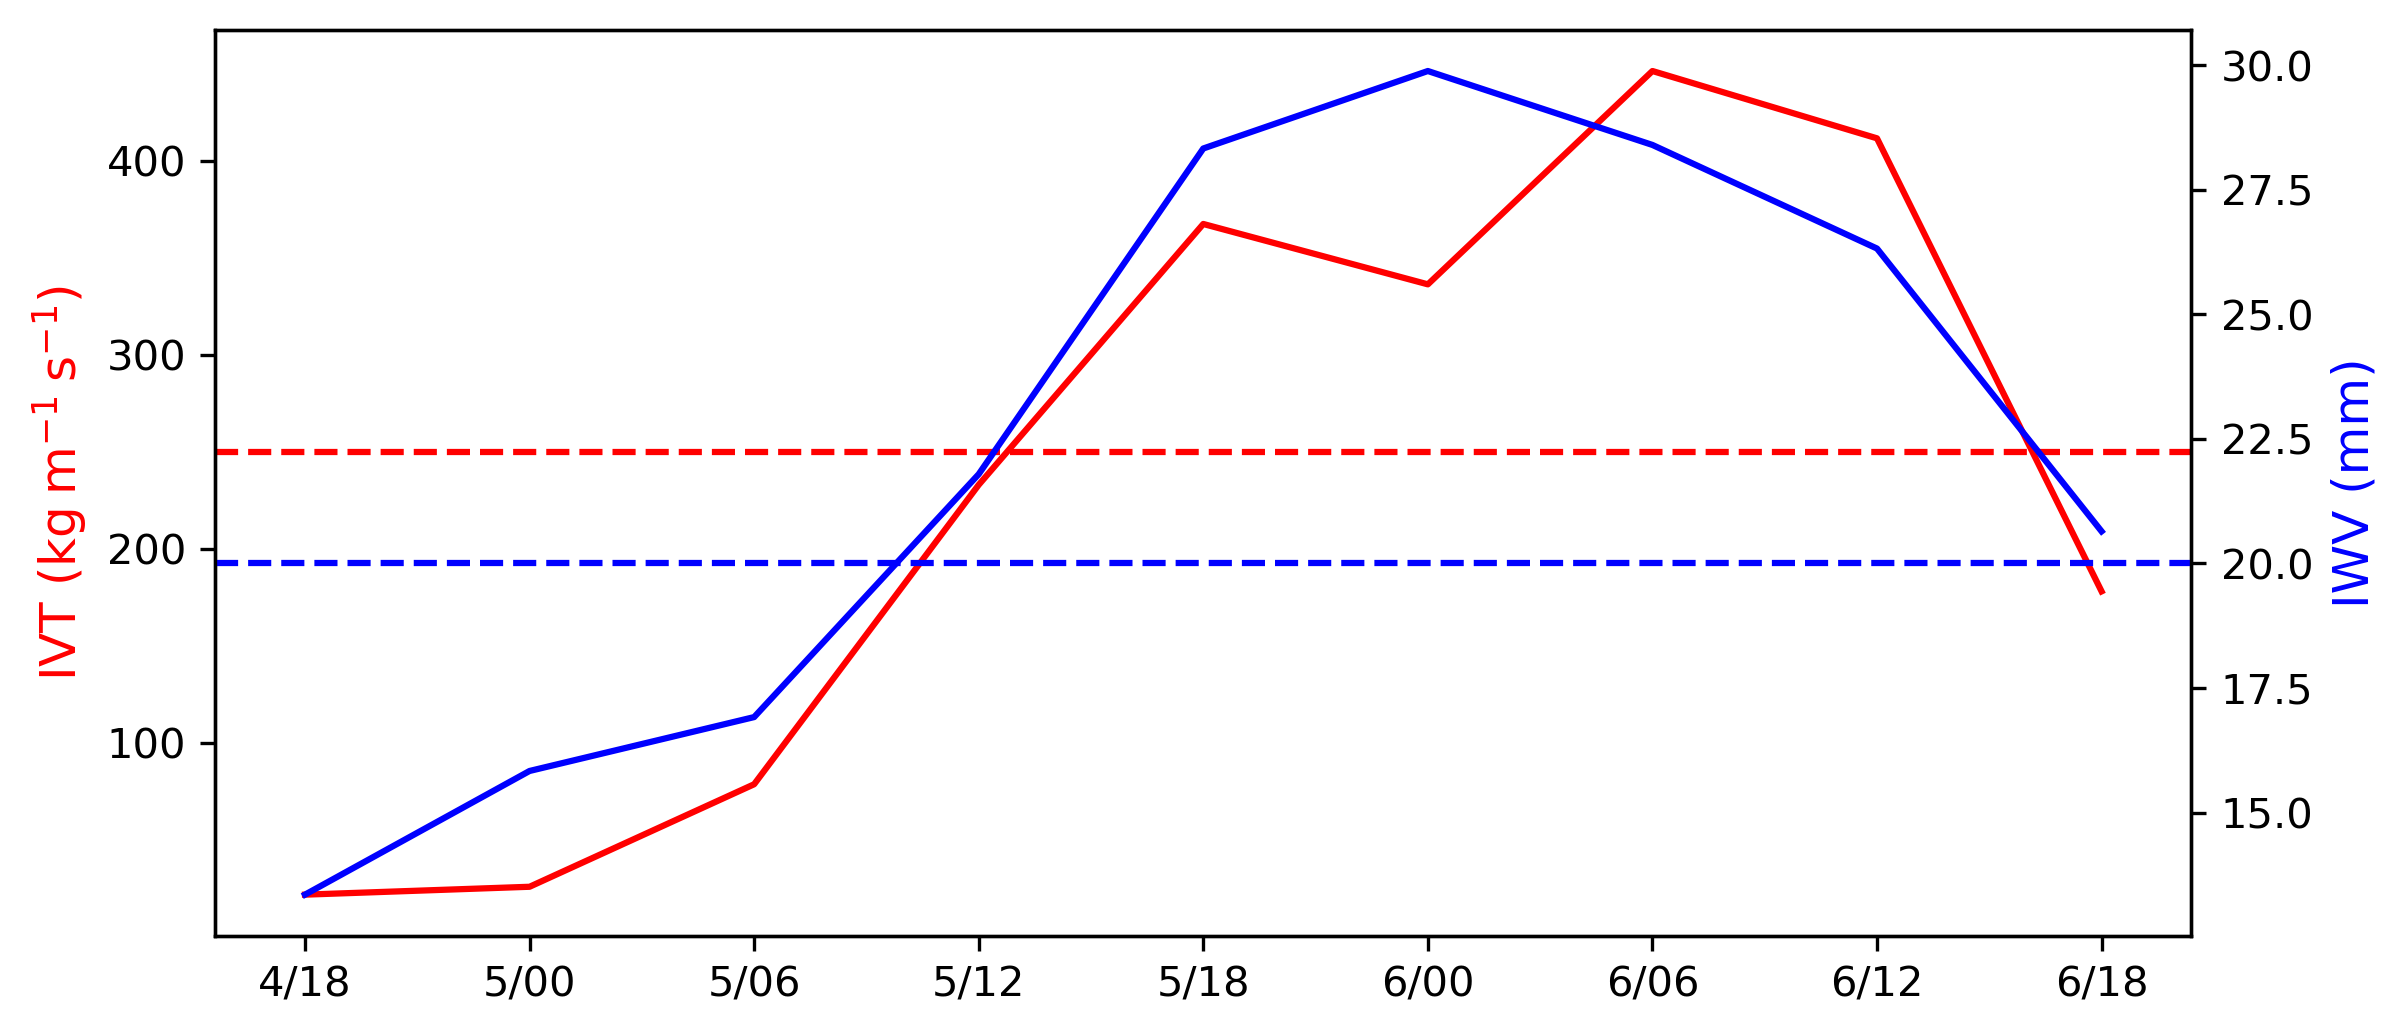

<Figure size 2550x1200 with 0 Axes>

In [5]:
fig = plt.figure(1, figsize=(8.5, 4.))
fig.dpi = 300
fname = './figures/fS4'
fmt1 = 'png'
fmt2 = 'pdf'

ax1 = plt.subplot(111)
ax1.plot(ivt_total, color='red')
ax1.set_ylabel('IVT $\mathrm{(kg \: m^{-1} \: s^{-1})}$', fontsize=12., color='red')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(iwv, color='blue')
ax2.set_ylabel('IWV (mm)', fontsize=12., color='blue')
ax2.tick_params(axis='y', labelcolor='black')


# horizontal line indicating the threshold
ax1.axhline(y=250.0, color='red', linestyle='--')
ax2.axhline(y=20.0, color='blue', linestyle='--')

xticklabels = ['4/18', '5/00', '5/06', '5/12', '5/18',
            '6/00', '6/06', '6/12', '6/18']
# locs, labels = xticks()            # Get locations and labels
plt.xticks(np.arange(9), xticklabels)  # Set locations and labels
plt.xlabel('day/time (UTC)')

# Show the plot
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))
    